In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Step 1: Download a dataset and preview images


In [3]:
!tar -xvf '/content/cifar100.tar'

cifar100/
cifar100/test/
cifar100/train/
cifar100/test/apple_9904.jpg
cifar100/test/aquarium_fish_132.jpg
cifar100/test/aquarium_fish_267.jpg
cifar100/train/apple_9904.jpg
cifar100/train/aquarium_fish_132.jpg
cifar100/train/aquarium_fish_267.jpg


# Step 2: Custom Data Loading

In [1]:
import os
import time
import glob
import torch
import shutil
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential as Seq


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

sd = 42
set_seed(sd)

def worker_init_fn(worker_id):
    np.random.seed(sd + worker_id)

config = {
    "data_path": os.path.join(".", "cifar100", "cifar100"),
    "batch_size":128,
}

if not os.path.exists(config["data_path"]):
    raise FileNotFoundError(f"Data path {config['data_path']} does not exist. Please check the path.")
else:
    print(f"Data path {config['data_path']} found.")

class mydataset(Dataset):
    def __init__(self, data_dir, flag, transform):
        super(mydataset,self).__init__()
        self.root       = data_dir
        self.label      = flag
        self.transform  = transform

        self.img_dir = os.path.join(self.root, self.label)
        self.img_names  = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    def RGB2FF(self, img:torch.tensor):
        fft_result = torch.fft.fftn(img, dim=[1, 2])
        fft_result = torch.fft.fftshift(fft_result, dim=[1, 2])

        height, width = img.shape[1], img.shape[2]
        center_width = width // 8
        center_height = height // 8
        fft_result[:, height//2-center_height//2:height//2+center_height//2,
                      width//2-center_width//2:width//2+center_width//2] = 0.0
        fft_result = torch.fft.ifftshift(fft_result, dim=[1, 2])
        fft_result = torch.fft.ifftn(fft_result, dim=[1, 2]).real
        return fft_result

    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        # print(f"Opening image: {img_name}")
        img = Image.open(os.path.join(img_name))
        img = self.transform(img)

        freq = self.RGB2FF(img)

        for i in range(len(self.tags)):
            if self.tags[i] in img_name:
                tag = i
                break

        return img, freq, tag

    def __len__(self):
        return len(self.img_names)

# transform_train = transforms.Compose(
#         [transforms.Resize([64, 64]),
#          transforms.ToTensor()])

# data augmentation
transform_train = transforms.Compose([
    transforms.Resize([64, 64]),                 
    transforms.RandomHorizontalFlip(p=0.5),       
    transforms.RandomRotation(15),              
    transforms.ColorJitter(brightness=0.2,       
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomResizedCrop(64,            
                                 scale=(0.8, 1.0),
                                 ratio=(0.9, 1.1)),
    transforms.ToTensor(),                         
])



transform_test = transforms.Compose(
    [transforms.Resize([64, 64]),
      transforms.ToTensor()])

train_dataset = mydataset(data_dir=config['data_path'], flag= "train", transform=transform_train)
test_dataset  = mydataset(data_dir=config['data_path'], flag= "test", transform=transform_test)

# define data loader
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=8, pin_memory=True, drop_last=False, worker_init_fn=worker_init_fn)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=8, pin_memory=True, drop_last=False, worker_init_fn=worker_init_fn)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")    

# print("start")
# for i, (images, labels) in enumerate(train_loader):
#     print(i)

Data path ./cifar100/cifar100 found.
Train dataset size: 50000
Test dataset size: 10000


# Step 3: Configure the Neural Network

In [7]:
class CommonBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(CommonBlock, self).__init__()
        self.residual_branch = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # return nn.LeakyReLU(inplace=True)(self.residual_branch(x) + self.shortcut(x))
        return nn.ReLU(inplace=True)(self.residual_branch(x) + self.shortcut(x))

# class CommonBlock(nn.Module):
#     def __init__(self, in_channel, out_channel, stride):        # 普通Block简单完成两次卷积操作
#         super(CommonBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channel)
#         self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channel)

#     def forward(self, x):
#         identity = x                                            # 普通Block的shortcut为直连，不需要升维下采样

#         x = F.relu(self.bn1(self.conv1(x)), inplace=True)       # 完成一次卷积
#         # x = F.leaky_relu(self.bn1(self.conv1(x)), inplace=True)   
#         x = self.bn2(self.conv2(x))                             # 第二次卷积不加relu激活函数

#         x += identity                                           # 两路相加
#         return F.relu(x, inplace=True)                          # 添加激活函数输出
#         # return F.leaky_relu(x, inplace=True)                       

# class SpecialBlock(nn.Module):                                  # 特殊Block完成两次卷积操作，以及一次升维下采样
#     def __init__(self, in_channel, out_channel, stride):        # 注意这里的stride传入一个数组，shortcut和残差部分stride不同
#         super(SpecialBlock, self).__init__()
#         self.change_channel = nn.Sequential(                    # 负责升维下采样的卷积网络change_channel
#             nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
#             nn.BatchNorm2d(out_channel)
#         )
#         self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride[0], padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channel)
#         self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channel)

#     def forward(self, x):
#         identity = self.change_channel(x)                       # 调用change_channel对输入修改，为后面相加做变换准备

#         x = F.relu(self.bn1(self.conv1(x)), inplace=True)
#         # x = F.leaky_relu(self.bn1(self.conv1(x)), inplace=True)
#         x = self.bn2(self.conv2(x))                             # 完成残差部分的卷积

#         x += identity
#         return F.relu(x, inplace=True)                          # 输出卷积单元
#         # return F.leaky_relu(x, inplace=True)

class ConvNet(nn.Module):
    def __init__(self, block, layers, num_classes=100, inter_layer=False):
        super(ConvNet, self).__init__()
        self.inter_layer = inter_layer
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
            # nn.LeakyReLU(0.2, inplace=True)
        )

        self.stage2 = self._make_layer(block, 64, layers[0], 1)
        self.stage3 = self._make_layer(block, 128, layers[1], 2)
        self.stage4 = self._make_layer(block, 256, layers[2], 2)
        self.stage5 = self._make_layer(block, 512, layers[3], 2)
        # self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x1 = self.stage2(x)
        x2 = self.stage3(x1)
        x3 = self.stage4(x2)
        x4 = self.stage5(x3)
        x_avg = self.avg_pool(x4)
        x_flat = x_avg.view(x_avg.size(0), -1)
        x_out = self.fc(x_flat)
        if self.inter_layer:
            return [x1, x2, x3, x4, x_out]
        else:
            return x_out

# concat two branches, add additional attention layer to fuse the features
# did not perform much better than simply '+' the two branches.
class AttentionFusion(nn.Module):
    def __init__(self, in_channels):
        super(AttentionFusion, self).__init__()
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, feat1, feat2):
        combined = torch.cat([feat1, feat2], dim=1)
        attention = self.conv(combined)
        attention = self.bn(attention)
        attention = self.sigmoid(attention)
        # TODO: modify to feat1 * attention_1 + feat2 * attention_2
        return feat1 * attention + feat2 * (1 - attention)

class DualBranchNet(nn.Module):
    def __init__(self, classes_num):
        super(DualBranchNet, self).__init__()
        # resnet 18
        self.original_branch = ConvNet(CommonBlock, [2, 2, 2, 2], num_classes=classes_num, inter_layer=True)
        self.freq_branch = ConvNet(CommonBlock, [2, 2, 2, 2], num_classes=classes_num, inter_layer=True)

        # self.original_branch = ConvNet(classes_num)
        # self.freq_branch = ConvNet(classes_num)

        self.attention_layers = nn.ModuleList([
            AttentionFusion(64),
            AttentionFusion(128),
            AttentionFusion(256),
            AttentionFusion(512)
        ])
        
        # self.fc = nn.Sequential(
        #     nn.Linear(512, classes_num)
        # )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, classes_num)
        )

    def forward(self, x_orig, x_freq):
        feats_orig = self.original_branch(x_orig)
        feats_freq = self.freq_branch(x_freq)

        fused_feats = [self.attention_layers[i](feats_orig[i], feats_freq[i]) for i in range(4)]

        x = F.adaptive_avg_pool2d(fused_feats[-1], (1, 1))
        x = x.view(x.size(0), -1)
        return self.fc(x)


config = {
    "lr":1e-2,
    "momentum":0.9,
    "weight_decay":1e-4,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DualBranchNet(classes_num=100).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
# optimizer = torch.optim.Nadam(net.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

# Step 4: Train the network and save model

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val   = 0
        self.avg   = 0
        self.sum   = 0
        self.count = 0

    def update(self, val, n=1):
        self.val   = val
        self.sum   += val * n
        self.count += n
        self.avg   = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = correct[:maxk].reshape(-1).float().sum(0)
    res = res.mul_(100.0 / batch_size)
    return res

def train(train_loader, net, optimizer, criterion, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    top1       = AverageMeter()
    LOSS = AverageMeter()

    net.train()

    end = time.time()
    for i, (img, freq, target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)

        img = img.to(device)
        freq = freq.to(device)
        target = target.to(device)

        out = net(img, freq)
        
        loss = criterion(out, target)

        prec1 = accuracy(out, target)
        top1.update(prec1.item(), img.size(0))

        LOSS.update(loss.item(), img.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 1:
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                       'Time:{batch_time.val:.4f} '
                       'Data:{data_time.val:.4f}  '
                       'loss:{loss.val:.4f}({loss.avg:.4f})  '
                       'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                       epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                       loss=LOSS,
                       top1=top1))
            print(log_str)

    return LOSS.avg

def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()

    net.eval()

    with torch.no_grad():
        for i, (img, freq, target) in enumerate(test_loader, start=1):
            img = img.to(device)
            freq = freq.to(device)
            target = target.to(device)

            out = net(img, freq)
            loss = criterion(out, target)

            prec1 = accuracy(out, target)
            losses.update(loss.item(), img.size(0))
            top1.update(prec1.item(), img.size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg

def save_checkpoint(state, is_best, save_root, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    # save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    # torch.save(state, save_path)
    if is_best:
        best_save_path = os.path.join(save_root, 'model_best.pth.tar')
        torch.save(state, best_save_path)

config = {
    "save_root": "./result",
    "epochs": 100,
}

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])

best_top1 = 0
for epoch in range(1, config["epochs"] + 1):
    epoch_start_time = time.time()
    print('Epoch: {}'.format(epoch))
    train_loss = train(train_loader, net, optimizer, criterion, epoch)

    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print('current_lr:', current_lr)
    epoch_duration = time.time() - epoch_start_time
    print('Epoch time: {}s'.format(int(epoch_duration)))

    test_top1 = test(test_loader, net, criterion)

    is_best = test_top1 > best_top1
    best_top1 = max(test_top1, best_top1)
    print('Saving models......')
    save_checkpoint({
        'epoch': epoch,
        'net': net.state_dict(),
        'prec@1': test_top1,
    }, is_best, config["save_root"], epoch)


Epoch: 1
Epoch[1]:[001/391] Time:0.4359 Data:0.3550  loss:4.7335(4.7335)  prec@1:2.34(2.34)  
Epoch[1]:[051/391] Time:0.1754 Data:0.0001  loss:4.3195(4.3706)  prec@1:8.59(8.07)  
Epoch[1]:[101/391] Time:0.1757 Data:0.0001  loss:4.0821(4.2318)  prec@1:7.81(8.11)  
Epoch[1]:[151/391] Time:0.1762 Data:0.0001  loss:4.0104(4.1340)  prec@1:9.38(8.41)  
Epoch[1]:[201/391] Time:0.1761 Data:0.0001  loss:3.8156(4.0597)  prec@1:11.72(8.69)  
Epoch[1]:[251/391] Time:0.1766 Data:0.0001  loss:3.6794(4.0026)  prec@1:11.72(8.94)  
Epoch[1]:[301/391] Time:0.1762 Data:0.0001  loss:3.5927(3.9584)  prec@1:9.38(9.19)  
Epoch[1]:[351/391] Time:0.1766 Data:0.0002  loss:3.6526(3.9120)  prec@1:13.28(9.63)  
current_lr: 0.009997532801828659
Epoch time: 69s
---------------------------------test classification result---------------------------------
Loss: 4.1101, Prec@1: 8.40%
Saving models......
Epoch: 2
Epoch[2]:[001/391] Time:0.4375 Data:0.3602  loss:3.4290(3.4290)  prec@1:20.31(20.31)  
Epoch[2]:[051/391] Tim

# Step 5: Test on single image

In [8]:
img = Image.open("./cifar100/cifar100/test/apple_9904.jpg")
img = transform_test(img).unsqueeze(0)
freq = test_dataset.RGB2FF(img)
img = img.to(device)
freq = freq.to(device)
out = net(img, freq)
predicted_classes = torch.argmax(out, dim=1)
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

print(tags[predicted_classes[0]])

hamster


# Step 6: Evaluate model accuracy

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res[0]

def load_model(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['net'])
    print(f"Model loaded from {checkpoint_path} with accuracy: {checkpoint.get('prec@1', 'N/A')}")
    return model

def test(test_loader, net, criterion, device):
    losses = AverageMeter()
    top1 = AverageMeter()

    net.eval()

    with torch.no_grad():
        for i, (img, freq, target) in enumerate(test_loader, start=1):
            img = img.to(device)
            freq = freq.to(device)
            target = target.to(device)

            out = net(img, freq)
            loss = criterion(out, target)

            prec1 = accuracy(out, target)
            losses.update(loss.item(), img.size(0))
            top1.update(prec1.item(), img.size(0))

    print('---------------------------------test classification result---------------------------------')
    print(f'Loss: {losses.avg:.4f}, Prec@1: {top1.avg:.2f}%')
    return top1.avg

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DualBranchNet(classes_num=100).to(device)
checkpoint_path = "./result/model_best.pth.tar"
model = load_model(model, checkpoint_path, device)

criterion = nn.CrossEntropyLoss().to(device)

test_top1 = test(test_loader, model, criterion, device)


Model loaded from ./result/model_best.pth.tar with accuracy: 66.73


/tmp/ipykernel_3590066/278000673.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


---------------------------------test classification result---------------------------------
Loss: 2.5991, Prec@1: 66.73%


# Step 7: T-SNE Visualization

##Use hooks in PyTorch to extract feature representations from the intermediate layers of the model for the test set "testloader", and visualize them using the T-SNE method. The specific requirements are as follows:
####Visualize the features before and after the dual-branch feature fusion. If there are multiple fusions, you may choose specific layers for visualization.


Model loaded from ./best_models/66.73/result/model_best.pth.tar with accuracy: 66.73


/tmp/ipykernel_3590066/4238882364.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


---------------------------------test classification result---------------------------------
Loss: 2.5991, Prec@1: 66.73%


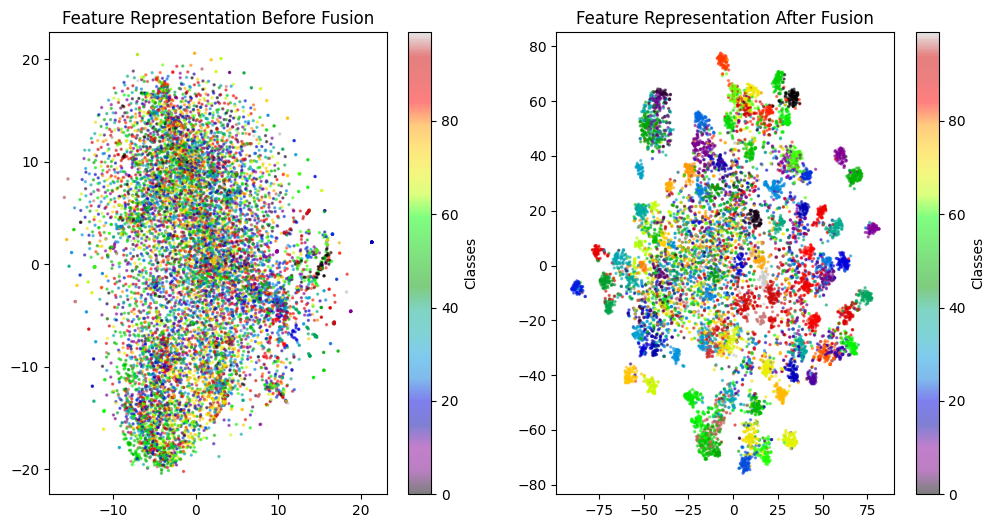

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
import os

features_before_fusion = []
features_after_fusion = []
all_targets = []

def load_model(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['net'])
    print(f"Model loaded from {checkpoint_path} with accuracy: {checkpoint.get('prec@1', 'N/A')}")
    return model

class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res[0]

def get_before_fusion_hook(module, input, output):
    features_before_fusion.append(output.detach().cpu())

def get_after_fusion_hook(module, input, output):
    features_after_fusion.append(output.detach().cpu())

def test_and_extract_features(test_loader, net, criterion, device):
    losses = AverageMeter()
    top1 = AverageMeter()

    net.eval()

    hook_handles = []
    hook_handles.append(net.attention_layers[1].register_forward_hook(get_before_fusion_hook))
    hook_handles.append(net.fc[1].register_forward_hook(get_after_fusion_hook))

    global all_targets

    with torch.no_grad():
        for i, (img, freq, target) in enumerate(test_loader, start=1):
            img, freq, target = img.to(device), freq.to(device), target.to(device)

            out = net(img, freq)
            loss = criterion(out, target)

            prec1 = accuracy(out, target)
            losses.update(loss.item(), img.size(0))
            top1.update(prec1.item(), img.size(0))

            all_targets.append(target.detach().cpu())

    print('---------------------------------test classification result---------------------------------')
    print(f'Loss: {losses.avg:.4f}, Prec@1: {top1.avg:.2f}%')

    for handle in hook_handles:
        handle.remove()

    return top1.avg

def visualize_features():
    features_before_fusion_concat = torch.cat([f.view(f.size(0), -1) for f in features_before_fusion], dim=0)
    features_after_fusion_concat = torch.cat([f.view(f.size(0), -1) for f in features_after_fusion], dim=0)
    all_targets_concat = torch.cat(all_targets, dim=0)

    features_before_fusion_np = features_before_fusion_concat.numpy()
    features_after_fusion_np = features_after_fusion_concat.numpy()
    all_targets_np = all_targets_concat.numpy()

    tsne = TSNE(n_components=2, random_state=0)
    features_before_fusion_2d = tsne.fit_transform(features_before_fusion_np)
    features_after_fusion_2d = tsne.fit_transform(features_after_fusion_np)

    norm = plt.Normalize(vmin=0, vmax=99)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(features_before_fusion_2d[:, 0], features_before_fusion_2d[:, 1], c=all_targets_np, cmap='nipy_spectral', norm=norm, alpha=0.5, s=2)
    plt.title("Feature Representation Before Fusion")
    plt.colorbar(label="Classes")
    
    plt.subplot(1, 2, 2)
    plt.scatter(features_after_fusion_2d[:, 0], features_after_fusion_2d[:, 1], c=all_targets_np, cmap='nipy_spectral', norm=norm, alpha=0.5, s=2)
    plt.title("Feature Representation After Fusion")
    plt.colorbar(label="Classes")

    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DualBranchNet(classes_num=100).to(device)
checkpoint_path = "./best_models/66.73/result/model_best.pth.tar"
model = load_model(model, checkpoint_path, device)

config = {
    "data_path": os.path.join(".", "cifar100", "cifar100"),
    "batch_size": 128,
}

transform_test = transforms.Compose([
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

test_dataset = mydataset(data_dir=config['data_path'], flag="test", transform=transform_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True, drop_last=False
)

criterion = nn.CrossEntropyLoss().to(device)

test_top1 = test_and_extract_features(test_loader, model, criterion, device)

visualize_features()
